In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# define some matplotlib style for all figures
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
def load_single(path):
    # prior on the name
    start = 'C1'
    end = '0'
    
    last = len(path)-path[::-1].find(start[::-1])
    perc = path[last:path.find(end)]
    
    if perc == '':
        perc = '0'
    
    with open(path) as f:
        lines = f.readlines()[5:]    
        v = np.zeros((len(lines), 2))
    
        for i, l in enumerate(lines):
            split = l.split(',')
            v[i,0] = float(split[0])
            v[i,1] = float(split[1])
    
        return v, 100*float(perc)/255 

def load_all(path, files):
    v_list = []
    perc_list = []
    for f in files:
        v, v_true = load_single(op.join(path,f))
        
        v_list.append(v)
        perc_list.append(v_true)
        
    return v_list, perc_list

def get_color(ind):
    colors = ['#0072BD', '#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE','#A2142F']
    return colors[ind%len(colors)]

In [3]:
# import data
root = op.join('data','pwm')
files = ['C1000002.txt', 'C16300000.txt', 'C112700000.txt', 'C119100000.txt', 'C125500000.txt']
v_all, perc_list = load_all(root, files)
print(perc_list)

[0.0, 24.705882352941178, 49.80392156862745, 74.90196078431373, 100.0]


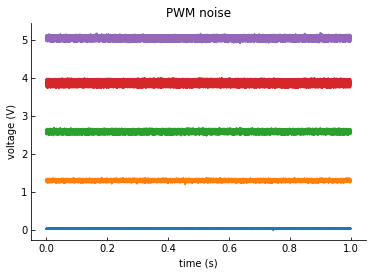

In [4]:
plt.figure()
for v in v_all:
    plt.plot(v[:,0]-np.min(v[:,0]),v[:,1])
plt.title('PWM noise')
plt.xlabel('time (s)')
plt.ylabel('voltage (V)')

dir_path = 'figs'
if not os.path.isdir(dir_path): os.mkdir(dir_path)
plt.savefig(op.join(dir_path,'fig_pwm_noise.eps'), format='eps')

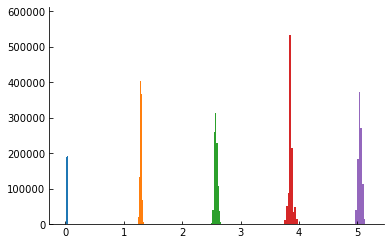

In [5]:
# histogram
ax = plt.subplot(111)
for v in v_all:
    plt.hist(v[:,1])

In [6]:
# Compute means
v_mean = np.zeros((len(v_all),))
v_std = np.zeros((len(v_all),))
for i, vals in enumerate(v_all):
    v_mean[i] = np.mean(vals[:,1])
    v_std[i] = np.std(vals[:,1])
v_mean_perc = 100*v_mean/5
v_std_perc = 100*v_std/5
    
s_x = 'duty cycle (%)'
s_y = 'analog output (V)'
s_std = 'Std (V)'
s_y_perc = 'analog output (%)'
s_std_perc = 'Std (%)'
df = pd.DataFrame({s_x: perc_list, s_y: v_mean, s_std: v_std, s_y_perc: v_mean_perc, s_std_perc: v_std_perc})
print(df)

   duty cycle (%)  analog output (V)   Std (V)  analog output (%)   Std (%)
0        0.000000           0.029984  0.004815           0.599689  0.096308
1       24.705882           1.295052  0.016192          25.901047  0.323839
2       49.803922           2.577667  0.026757          51.553345  0.535138
3       74.901961           3.855817  0.033793          77.116338  0.675853
4      100.000000           5.046062  0.027883         100.921236  0.557652


In [7]:
# Linear regression
perc = np.array(perc_list)
res = stats.linregress(perc, v_mean_perc)
print(res)
print(f"R-squared: {res.rvalue**2:.6f}")

LinregressResult(slope=1.0066186536532706, intercept=1.005824012633731, rvalue=0.9998894824061414, pvalue=1.3946774830609291e-06, stderr=0.00864114027500737)
R-squared: 0.999779


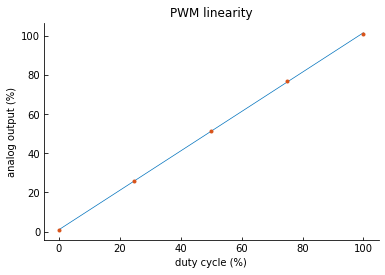

In [8]:
ax = plt.subplot(111)
plt.plot(perc, res.intercept + res.slope*perc, '-', color = get_color(0), linewidth = 0.7)
plt.plot(perc, v_mean_perc, '.', color = get_color(1))

#plt.ylim([-0.1, 1])
#plt.xlim([-0.1, 1])

plt.title('PWM linearity')
plt.xlabel(s_x)
plt.ylabel(s_y_perc)

dir_path = 'figs'
if not os.path.isdir(dir_path): os.mkdir(dir_path)
plt.savefig(op.join(dir_path,'fig_3a_pwm_linear.eps'), format='eps')